## Overview
This project focuses on the analysis of when movie studios should release movies for the sole purpose of generating as much revenue as possible. Specifically, an analysis is done to figure out what the best period of time is to release a movie depending on the genre of the movie. These periods of time are broken into two categories. The first category comprises of the different seasons of the year - Spring, Summer, Fall and Winter. The second category comprises of all the major holiday periods throughout the year in the U.S - Halloween, Thanksgiving, Christmas, New Years, and Valentine’s Day.

## Names
* Bryan Cook
* Jimmy Dang
* Jasmine Hoang
* Lisa Luo
* Anton Preis
* Jordan Yick

## Group Members IDs
* A11707607
* A14876397
* A14578079
* A14832194
* A14124139
* A14670220

## Research Question
Is there a relationship between the time of year, which are defined by holidays and seasons,  that movies are released and the revenue that these movies generate? If there is a relationship, what is the best time of year to release certain genres of movies in order to generate the most revenue?

## Background and Prior Work
The content of a movie is not the sole determiner of how much revenue a movie generates. In order to generate the most revenue, movie studios must take into account the demographics of the audience, the time in which a movie is released, advertisements for a movie, the cultural climate, and so on (New York Times). Movie studios put a lot of effort into planning when movies will be released in order to generate as much revenue as possible. An example of this type of planning is when production companies take “dump months” into account. Looper states that “dump months” are times of the year, such as January and September, when movies tend to perform worse than movies released during the rest of the year. Because of these low-producing months, production companies tend to release movies that would not perform too well in other months during “dump months” in order to give them the best chance at success, while movies that are predicted to do well are released during the summer blockbuster months. The movies that studios expect to do well are called tentpole movies and are usually released between May to September (Sarantinos). After this round of releases, studios will tend to make the majority of their money that will allow for funding for smaller, less profitable films. 

According to a research report by IBISWorld, the U.S. film industry generated $33 billion in 2019. The film industry is an important part of the country’s economy and plays a major role in the lives of average Americans. As the film industry continues to grow, movie companies will want more data analysis and information to make smarter, more informed decisions on when to release movies. It is our intuition that an analysis that focuses on the time in which movies are released in relation to the genre of a particular movie is a pertinent piece of the puzzle in figuring out how to maximize revenue for movie studios. 

References:
* 1) How the film industry makes money:  
https://www.nytimes.com/2012/07/01/magazine/how-does-the-film-industry-actually-make-money.html 
* 2) The untold truth of movie dump months:  
https://www.looper.com/101784/untold-truth-movie-dump-months/
* 3) What is the Difference Between a Blockbuster and Tentpole Movie by J. Gideon Sarantinos:  
https://gideonsway.wordpress.com/2013/11/23/what-is-the-difference-between-a-blockbuster-and-tentpole-movie/
* 4) Movie & Video Production Industry in the US - Market Research Report:  
https://www.ibisworld.com/united-states/market-research-reports/movie-video-production-industry/


## Hypothesis
We hypothesize that based on a given movie genre, there is a relationship between when a movie is released and the revenue generated from the film. Based on our own real-life observations, we have noticed that family movies tend to release during Christmastime and Summer, romantic comedies tend to release during Valentine’s Day, etc., and we’ve noticed that these movies tend to perform well. Because of these observations, we believe that there will be a relationship between these factors.

To be more specific for our statistical Ordinary Least Squares (OLS) test:
* H$_{0}$: For movies in the given genre, there is no relationship between the time of year the movie was released and the revenue it generates.
* H$_{A}$: For movies in the given genre, there is a relationship between the time of year the movie was released and the revenue it generates.
* 𝛼 = 0.01


## Dataset
Dataset Name: The Movies Dataset  
Link to Dataset: https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv  
Number of Observations: 45000  
Description of Dataset: This dataset contains information, such as movie title, cast, and ratings, on 45,000 movies that we were released before July 2017. We will be using the movie title, release date, and revenue information, which already takes inflation into account, from this dataset.

## Setup
These are the packages we imported to process and analyze our data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import datetime
import json
import math

import scipy.stats as stats
from scipy.stats import normaltest

import statsmodels.api as sm
import patsy

## Data Cleaning

Our dataset was incredibly large and had a ton of superfluous information not related to our question of interest. Since our main focus was on movie revenue, genre, and release date, we cleaned up and removed a lot of the columns that we did not need.

### Threshold Values and Global Variables
These are threshold values and global data structures that we used to process our data and hold our data.

In [2]:
# Minimum revenue that a movie should have to be kept in the dataset
revenue_thres = 1000

# Significance value to reject the null hypothesis
alpha = 0.01

# Movie dataset
movies_dataset = None

# Data structure to divide each genre into the time periods
# 
# key - genre : str
# value - {
#           release_date_period: [
#                                  revenue : int,
#                                  number of movies : int,
#                                  average revenue : float
#                                ]
#          }
genre_dict = {}

# Data structure to hold data points for each 
# 
# key - genre : str
# value - {
#           release_date_period: [ data points : int ]
#         }
genre_datapoints = {}

# Same format as genre_datapoints but the datapoints have been normalized
normalized_datapoints = {}

# Stores a reference to all of our time periods
time_periods = {}

# Stores a Pandas dataframe for each genre
dataframe_dict = {}

# Results data structure to store the pairings that passed and failed
#
# Each element is of form (genre, time_period)
passed_pairs = []
failed_pairs = []

### Helper Functions
These are helper functions that we used to parse our data from the dataset and various other repetitive tasks, such as comparing datetimes and conducting statistical tests.

`parse_date()` was used to convert release dates from the dataset into datetime objects for easy comparison later.

In [3]:
# convert to datetime object
def parse_date(date_str):
    '''This function returns a datetime representation of the passed in date
    
    Parameters
    ----------
    date_str : str, any
        The string representation of our date
        Must be in the format of YYYY-MM-DD
    
    Returns
    -------
    datetime.datetime
        datetime object representation of the passed in date
    returns a datetime representation of the date string
    '''
    
    # guarantee that the date_str is a string
    date_str = str(date_str)
    
    # split the date_str
    split_date = date_str.split('-')
    
    # convert to ints
    year = int(split_date[0])
    month = int(split_date[1])
    day = int(split_date[2].split(' ')[0])
    
    return datetime.datetime(year, month, day)

`parse_genre()` was used to parse all the genres from our dataset. In the dataset, the genres were contained in a json format, so we needed this function to extract each unique genre.

In [4]:
def parse_genre(genre):
    '''This function parses the genre string from our dataset into a list of the genres
    
    Parameters
    ----------
    genre : str
        The string containing all of the genres of a single movie
    
    Returns
    -------
    list of str
        A list containing all of the genres that were parsed
    '''
    
    # convert the genre string to a json object
    genre_list = json.loads(genre.replace("\'", '\"'))
    all_genres = []
    
    # retrieve each genre from the json object
    for element in genre_list:
        all_genres.append(element['name'])

    return all_genres

`is_in_daterange()` was used was to test if a movie's release date fell into one of our predefined ranges of dates.

In [5]:
def is_in_daterange(date, start, end):
    '''This function determines if the given date is within the start and end date
    
    Parameters
    ----------
    date : datetime.datetime
        The date that we want to check
    start : datetime.datetime
        The start date of our interval
    end : datetime.datetime
        The end date of our interval
    
    Returns
    -------
    bool
        True if date is within the interval, False otherwise
    '''
    new_start = datetime.datetime(date.year, start.month, start.day)
    new_end = datetime.datetime(date.year + 1, end.month, end.day)
    
    return new_start <= date and date <= new_end

`create_datetime_ranges()` was used to create all of the datetime ranges that we defined for the holidays and the seasons. The holidays that we selected are Thanksgiving, Christmas, New Years, and Valentine's Day, and the seasons are Summer, Spring, Winter, and Fall. We represented these ranges with a start date and an end date. For the holidays, any movie released a week before or a week after the given holiday was considered a movie within the timeframe of the given holiday, except for Thanksgiving in which the timeframe is from Thanksgiving weekend to the last week of November. We treated Thanksgiving differently from the other holidays because the date of the holiday changes every year and we wanted to ensure that our time range would be appropriate.

In [6]:
def create_datetime_ranges():
    '''This function creates all of the datetime ranges that we have determined to be useful
    
    Returns
    -------
    dict of str and tuple of datetime.datetime and datetime.datetime
        A dictionary with the time period as the key and the value being the range for that time period.
    '''
        
    # Define holidays
    holidays = ['Thanksgiving', 'Valentines', 'Christmas', 'Halloween']
        
    thanksgiving_start = datetime.datetime(2019, 11, 20)
    thanksgiving_end = datetime.datetime(2019, 11, 30)

    valentines_start = datetime.datetime(2019, 2, 7)
    valentines_end = datetime.datetime(2019, 2, 21)

    christmas_start = datetime.datetime(2019, 12, 18)
    christmas_end = datetime.datetime(2019, 1, 8)

    halloween_start = datetime.datetime(2019, 10, 24)
    halloween_end = datetime.datetime(2019, 11, 7)

    holiday_ranges = [thanksgiving_start, thanksgiving_end, \
                      valentines_start, valentines_end, \
                      christmas_start, christmas_end, \
                      halloween_start, halloween_end]
    
    # Define seasons
    seasons = ['Summer', 'Spring', 'Winter', 'Fall']
    
    summer_start = datetime.datetime(2019, 6, 1)
    summer_end = datetime.datetime(2019, 8, 31)

    spring_start = datetime.datetime(2019, 3, 1)
    spring_end = datetime.datetime(2019, 5, 30)

    winter_start = datetime.datetime(2019, 12, 1)
    winter_end = datetime.datetime(2020, 2, 28)

    fall_start = datetime.datetime(2019, 9, 1)
    fall_end = datetime.datetime(2019, 11, 30)

    season_ranges = [summer_start, summer_end, \
                     spring_start, spring_end, \
                     winter_start, winter_end, \
                     fall_start, fall_end]
    
    
    time_periods = {}
    
    for i in range(len(holidays)):
        time_periods[holidays[i]] = (holiday_ranges[2 * i], holiday_ranges[2 * i + 1])
    
    for i in range(len(seasons)):
        time_periods[seasons[i]] = (season_ranges[2 * i], season_ranges[2 * i + 1])
        
    return time_periods

`run_stat_test()` was used to repeatedly run an OLS test on the given data. We created a helper method for this because we knew we would be possibly be testing every single genre and wanted to avoid code repetition.

In [7]:
def run_stat_test(genre, summary=True):
    '''This function will perform a OLS test on the given genre
    
    Parameters
    ----------
    genre : str
        The genre that we want to perform the test on
    summary (optional) : bool
        Default value is True, if we want to print out the summary, leave as is
        Otherwise, set to False if we want the regression results object
        
    Returns
    -------
    str
        The summary of the OLS regression test
    '''

    if genre not in dataframe_dict:
        return 'Error occured. Please ensure you\'ve initialized dataframe_dict properly.'
    
    # Run the OLS test
    outcome, predictors = patsy.dmatrices('Revenue ~ Time_Period', dataframe_dict[genre])
    mod = sm.OLS(outcome, predictors)
    res = mod.fit()
    
    # If we want a summary of our results, return summary
    if summary:
        return res.summary()
    
    return res

We chose to analyze movie revenues by analyzing the average revenues, and `compute_total_avg()` computes these averages for us.

In [8]:
def compute_total_avg():
    '''This function computes the average revenue of all of the movies in our dataset.
    Note that we only compute the average after we have cleaned our data but before normalizing.
    
    Returns
    -------
    dict of str and floats
        A dictionary where the key is the time_period and the value is the average revenue
    '''
    
    # Store our results in this dict
    average_revenues = {}
    
    # Temporary values while we're still adding up values
    # Format is key: time_period, value: [total_revenue, total_movies]
    time_period_totals = {}
    indiv_total = None
    
    # Iterate through the genre_dict data structure
    for period in genre_dict.values():
        for period_name, data in period.items():
            indiv_total = [0, 0]
            
            if period_name in time_period_totals:
                indiv_total = time_period_totals[period_name]
            
            # Revenue is stored in the first element of our inner array
            # Number of movies is stored in the second element of our inner array
            indiv_total[0] += data[0]
            indiv_total[1] += data[1]
            
            time_period_totals[period_name] = indiv_total
    
    # Now iterate through the time_period_totals to get the average to store in result
    for period_name, totals in time_period_totals.items():
        average_revenues[period_name] = totals[0] / totals[1]
    
    return average_revenues

### Data Cleaning Steps
Before loading the dataset into a dataframe, we used Excel to format the release dates in the dataset into one single format so that it would be easier for us to process.

We loaded the movies dataset into a dataframe so we could analyze it. We first removed movies that were not in English. Then, we set a revenue threshold of 1000 because we noticed a few 0 values in this column initially, and since movies usually never make 0 we counted this data as missing and removed it. We dropped movies that did not have any genres and that were not released to ensure that our data was relevant to our question. We used our `parse_date()` function to transform the dates in the csv into datetime objects. Then we removed all other columns that were not relevant to our research question.

In [9]:
# Load our dataset
movies_dataset = pd.read_csv('movies_metadata.csv', dtype={'popularity': str, 'adult': str, 'budget': str, 'id': str})

# Drop movies where English is not the primary language
movies_dataset = movies_dataset[movies_dataset['original_language'] == 'en']

# Drop movies where revenue does not meet the threshold 
movies_dataset = movies_dataset[movies_dataset['revenue'] > revenue_thres]

# Drop mvies with no genres (not applicable for our purposes)
movies_dataset = movies_dataset[movies_dataset['genres'].apply(lambda x: len(x) > 0)]

# Drop unreleased movies
movies_dataset = movies_dataset[movies_dataset['status'] == 'Released']

# Convert movie release dates to datetime objects using our parse_date function
movies_dataset['release_date'] = movies_dataset['release_date'].apply(parse_date)

# Drop all of the unnecessary columns
movies_dataset = movies_dataset.drop(columns=['adult',
                                              'belongs_to_collection',
                                              'budget',
                                              'homepage',
                                              'imdb_id',
                                              'original_language',
                                              'original_title',
                                              'overview',
                                              'popularity',
                                              'poster_path',
                                              'production_companies',
                                              'production_countries',
                                              'runtime',
                                              'spoken_languages',
                                              'status',
                                              'tagline',
                                              'video',
                                              'vote_average',
                                              'vote_count'])

After cleaning the dataset, we are left with five columns as shown below:

In [10]:
movies_dataset

,genres,id,release_date,revenue,title
155,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",618,1915-02-08,11000000.0,The Birth of a Nation
177,"[{'id': 18, 'name': 'Drama'}]",70368,1915-12-13,137365.0,The Cheat
208,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",30266,1916-12-24,8000000.0,"20,000 Leagues Under the Sea"
238,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",54242,1918-08-01,8000000.0,Mickey
297,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",10098,1921-01-21,2500000.0,The Kid
...,...,...,...,...,...
45254,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",378236,2017-07-28,66913939.0,The Emoji Movie
45262,"[{'id': 28, 'name': 'Action'}, {'id': 37, 'nam...",353491,2017-08-03,71000000.0,The Dark Tower
45263,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",395834,2017-08-03,184770205.0,Wind River
45265,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",293768,2017-08-04,24527158.0,Kidnap


Using the format of the data structures defined in the "Threshold Values and Global Variables" section, we iterate through each row of data in the `movie_dataset` and parse it accordingly. We first parse the row's genre and release date as these are the two values that will determine how we will insert our datapoint into `genre_dict` and `genre_datapoints`. This chunk of code will also help prepare our computation of the average for each genre + time period pair by keeping track of the number of movies that have been added to a pair.

In [11]:
# Initialize our time periods dictionary
time_periods = create_datetime_ranges()

# For each row:
for index, row in movies_dataset.iterrows():
    # Parse the genre and release date using our helper functions
    genres_list = parse_genre(row[0])
    release_date = parse_date(row[2])
    
    # For each genre within this movie entry
    for genre in genres_list:
        # Stores the dictionary for the data in each time period
        genre_data = {}
        
        # Stores the datapoints associated with each time period
        genre_points = {}
        
        # Pull existing dictionaries if they currently exist
        if genre in genre_dict:
            genre_data = genre_dict[genre]
            genre_points = genre_datapoints[genre]
        
        # Update each time period if the release date is within that time period
        # item is a tuple: ( time period str, ( start, end ) )
        for item in time_periods.items():
            # Check if in this period
            if is_in_daterange(release_date, item[1][0], item[1][1]):
                
                # Empty objects for the first access
                temp_data = [0, 0]
                temp_points = []
                
                # Pull if data already exists
                if item[0] in genre_data:
                    temp_data = genre_data[item[0]]
                    temp_points = genre_points[item[0]]
                
                # row[3] is revenue
                # temp_data[0] is the total revenue
                temp_data[0] = temp_data[0] + int(row[3])
                
                # temp_data[1] is the number of movies
                temp_data[1] = temp_data[1] + 1

                # Add the revenue as a datapoint - we take the log here to prevent skewed numbers
                temp_points.append(math.log(int(row[3])))
                
                # Add to our inner data structure before continuing to iterate
                genre_data[item[0]] = temp_data
                genre_points[item[0]] = temp_points
        
        # Update the outer data structure with our updated inner data structure
        genre_dict[genre] = genre_data
        genre_datapoints[genre] = genre_points

As mentioned earlier, this code will compute the average of each genre + time period pairing by using the two values that are currently stored in each inner-most entry of `genre_dict`. Element 0 of this list will contain the total revenue and element 1 of this list will contain the number of movies that were summed to get the total revenue.

After computing the average revenue, we add it as a third element to this list for future use.

In [12]:
# Iterate through the entire data structure and compute the average for each genre, time period pair
for genre_item in genre_dict.items():
    # Grab the key so we can later use for access
    key = genre_item[0]
    average_revenue = 0
    
    # For each time period, compute the average revenue within this genre
    for item in genre_item[1].items():
        inner_key = item[0]
        average_revenue = item[1][0] / item[1][1]

        # Append as the third element of the innermost array
        genre_dict[key][inner_key].append(average_revenue)

Here, after skimming through the number of data points, we determined that we should drop the entire entry for 'TV Movie'. This is because there was only one data point that had a genre of 'TV Movie' and as such, would not be helpful for our test.

In [13]:
# Delete data that is too small to work with
del genre_dict['TV Movie']
del genre_datapoints['TV Movie']

## Data Analysis & Results
### Data Visualization
Before performing statistical tests on our data, we want to visualize the data first.

The first chunk of this code will set up the graph environment for the rest of the graphs that are generated within this Jupyter Notebook. We also set up the data to be plotted as our current data structure is not in a format that `matplotlib`'s graphing utility will take in properly. The data format is now array of values, where each value is a tuple. Each tuple's first element is the genre. Each tuple's second element is a list of average revenue per time period.

In [14]:
# Setup the graph environment

# x-axis labels (time periods)
labels = [item for item in time_periods.keys()]
genre_graph_values = []

# Iterate through the entire genre data structure to format data for graphing
for key, val in genre_dict.items():

    # Iterate through every time period
    values = []
    for label in labels:
        # If data exists for it, then append it, otherwise append 0
        if label in val:
            values.append(val[label][2])
        else:
            values.append(0)
    
    genre_graph_values.append((key, values))

# Update font size so it's legible
matplotlib.rcParams.update({'font.size': 10})

# Evenly divide up the x-axis
y_pos = np.arange(len(labels))

In this snippet, we are plotting all of the average revenues between all of the time periods. This is to help show the difference between the success rate of one movie genre over the other.

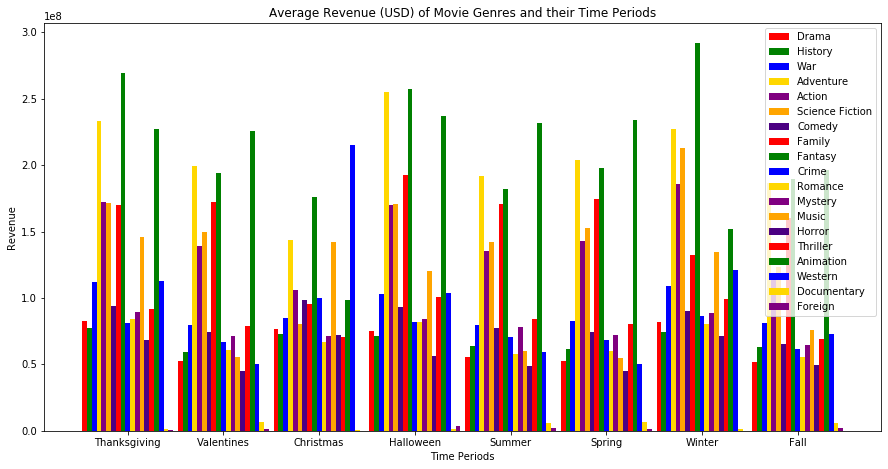

In [15]:
# Change the size of the graph so it's more readable
graph1, ax1 = plt.subplots(figsize=(15,7.5))

# Colors for graph, currently cycles through them
colors = ['red', 'green', 'blue', 'gold', 'purple', 'orange', 'indigo']

# Plot the first three genres in our list
starting_pos = -0.45
for i in range(19):
    ax1.bar(y_pos + starting_pos, genre_graph_values[i][1], width=0.05, label=genre_graph_values[i][0], color=colors[i % 7])
    starting_pos += 0.05

# Set x labels
ax1.set_xticks([i for i in range(8)])
ax1.set_xticklabels(labels)

# User-friendly configurations
ax1.legend()
ax1.set_xlabel('Time Periods')
ax1.set_ylabel('Revenue')
ax1.set_title('Average Revenue (USD) of Movie Genres and their Time Periods')

# Show graph
graph1.show()

The graph above exhibits the average revenue on the y-axis and time period on the x-axis. The different colored bars indicate different genres. Although this graph is quite clumped together, we wanted to plot all of the average revenues made for each genre given a certain time period. Based off a surface assumption, one might expect that movies with the genre of Romance would exhibit the highest average revenue for the Valentine’s period, however this is not the case. One might also expect that movies with the genre of Horror would exhibit the highest average revenue for the Halloween period, however this is not the case.

Moving on, we take a look at the overall revenue against the top performing movie genres. This code finds the indices of the values that we want to plot in the overall `genre_graph_values` array that we defined in the graph setup block. It stores these values and then plots it below.

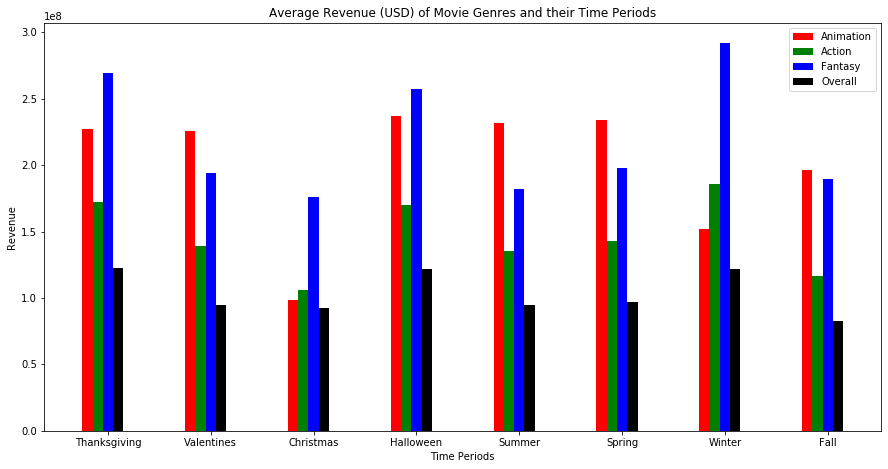

In [16]:
# Get the overall averages
temp_avg = compute_total_avg()

# Rearrange so the values are in the order for graphing
overall_avg = [temp_avg['Thanksgiving'], temp_avg['Valentines'], temp_avg['Christmas'], temp_avg['Halloween'], \
               temp_avg['Summer'], temp_avg['Spring'], temp_avg['Winter'], temp_avg['Fall']]


# Change the size of the graph so it's more readable
graph2, ax2 = plt.subplots(figsize=(15,7.5))

# Colors for graph
colors = ['red', 'green', 'blue']

# Plot overall against a genre
genres = ['Animation', 'Action', 'Fantasy'] # You can change this to different genres if you desire: Max 3
genre_idx = [-1, -1, -1]

# Iterate through array to find the index
for idx, genre in enumerate(genres):
    for i, val in enumerate(genre_graph_values):
        if val[0] == genre:
            genre_idx[idx] = i
            break

start_pos = -0.2
for i in range(3):
    ax2.bar(y_pos + start_pos, genre_graph_values[genre_idx[i]][1], width=0.1, label=genre_graph_values[genre_idx[i]][0], color=colors[i])
    start_pos += 0.1
    
ax2.bar(y_pos + start_pos, overall_avg, width=0.1, label='Overall', color='black')

#starting_pos += 0.2

# Set x labels
ax2.set_xticks([i for i in range(8)])
ax2.set_xticklabels(labels)

# User-friendly configurations
ax2.legend()
ax2.set_xlabel('Time Periods')
ax2.set_ylabel('Revenue')
ax2.set_title('Average Revenue (USD) of Movie Genres and their Time Periods')

# Show graph
graph2.show()

For the most part, the genres that we have chosen are all greater than the overall average revenue. This hints at the fact that our data might have a very large variance, meaning that there are movies that do horribly and movies that do amazingly.

Finally, this graph displays the top genres in a specific time period. We expected "Fantasy" to do the best and for comparison, we plotted what we believe are the next highest performing genres in this time period. The time period we have chosen is 'Thanksgiving'. The code is similar to the previous graph code blocks as it plots the values using the same `genre_graph_values` array but only plots a single value that is tied to the Thanksgiving time period.

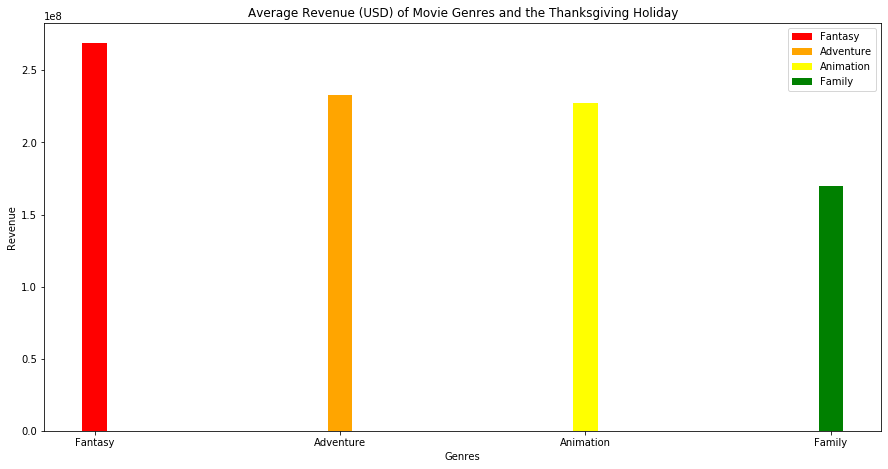

In [17]:
# Change the size of the graph so it's more readable
graph3, ax3 = plt.subplots(figsize=(15,7.5))

# Colors for graph, currently cycles through them
colors = ['red', 'orange', 'yellow', 'green']

# Time period that we want to show data for
graph3_time = labels.index('Thanksgiving')

# Plot the first three genres in our list
starting_pos = -0.2
for i, genre in enumerate([8, 3, 15, 7]):
    ax3.bar(i, genre_graph_values[genre][1][graph3_time], width=0.1, label=genre_graph_values[genre][0], color=colors[i])
    starting_pos += 0.1

# Set x labels
ax3.set_xticks([i for i in range(4)])
ax3.set_xticklabels([genre_graph_values[i][0] for i in [8, 3, 15, 7]])

# User-friendly configurations
ax3.legend()
ax3.set_xlabel('Genres')
ax3.set_ylabel('Revenue')
ax3.set_title('Average Revenue (USD) of Movie Genres and the Thanksgiving Holiday')

# Show graph
graph3.show()

# Normality Test
Before we conduct OLS tests, we first need to check and make sure that the data is normal. We first normalized the data and then performed normality tests on it.

In [18]:
# Testing for normality while also normalizing our datapoints

# Iterate through our datapoints
for genre, val in genre_datapoints.items():

    # Populate normalized datapoints with the same format as the genre_datapoints
    # Pull from normalized_datapoints if it currently exists
    temp_norm_genre_dict = {}
    if genre in normalized_datapoints:
        temp_norm_genre_dict = normalized_datapoints[genre]
    
    for time, points in val.items():
        # normaltest is only valid if there are more than 20
        if len(points) >= 20:
            normalized_data = stats.boxcox(points)
            test_stat, p_value = normaltest(normalized_data[0])
        
            # If our data isn't normal, then we don't save it
            if p_value > 0.01:
                temp_norm_genre_dict[time] = normalized_data

    normalized_datapoints[genre] = temp_norm_genre_dict

With the datapoints that we found to be normal, we now create a new dataframe with this data so we can perform OLS tests on it.

In [19]:
# Set up the data frames using the normalized datapoints
# Our data frame will have the format of two columns
# The first column is the time period, the second is the revenue
for genre, vals in normalized_datapoints.items():
    time_lst = []
    rev_lst = []
    
    # Append values to the list so we can build our dataframe
    for time, money in vals.items():
        for value in money[0]:
            time_lst.append(time)
            rev_lst.append(value)
            
    dataframe_dict[genre] = pd.DataFrame({ 'Time_Period': time_lst, 'Revenue': rev_lst })

We performed OLS linear regression on each genre, with time periods as the independent variable and revenue as the dependent variable. We used OLS tests because it allowed us to easily explore and see if there is a relationship between two variables.


In [20]:
# Run our test for each genre in the dataframes that we just created above
# This cell will print out our results one after another
for genre in dataframe_dict.keys():
    print('Running test for ' + genre)
    print(run_stat_test(genre))
    print('\n\n\n')

Running test for Drama
                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Thu, 12 Dec 2019   Prob (F-statistic):                nan
Time:                        22:49:36   Log-Likelihood:                -1783.6
No. Observations:                 174   AIC:                             3569.
Df Residuals:                     173   BIC:                             3572.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.939e+04    520.

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     398.9
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          8.65e-294
Time:                        22:49:37   Log-Likelihood:                -18361.
No. Observations:                1925   AIC:                         3.673e+04
Df Residuals:                    1919   BIC:                         3.677e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     643.7
Date:                Thu, 12 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:49:38   Log-Likelihood:                -30502.
No. Observations:                3016   AIC:                         6.102e+04
Df Residuals:                    3008   BIC:                         6.107e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     103.2
Date:                Thu, 12 Dec 2019   Prob (F-statistic):           1.59e-55
Time:                        22:49:39   Log-Likelihood:                -2233.1
No. Observations:                 311   AIC:                             4476.
Df Residuals:                     306   BIC:                             4495.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

#### Data we have to drop because it wasn't normalized:  
Drama Valentines  
Drama Thanksgiving   
Drama Halloween  
Drama Summer  
Drama Spring  
Drama Winter  
Drama Fall  
Adventure Valentines  
Adventure Summer  
Adventure Spring  
Action Valentines  
Action Spring  
Science Fiction Valentines  
Science Fiction Spring  
Comedy Valentines  
Comedy Summer  
Comedy Spring  
Comedy Halloween  
Comedy Fall  
Family Spring  
Fantasy Valentines  
Fantasy Spring  
Romance Valentines  
Romance Summer  
Romance Spring  
Romance Thanksgiving  
Mystery Christmas  
Music Christmas  
Horror Valentines  
Horror Summer  
Horror Spring  
Horror Fall  
Thriller Valentines  
Thriller Summer  
Thriller Spring  
Animation Valentines  
Animation Christmas  
Animation Summer  
Animation Spring  
Western Thanksgiving  
Western Christmas  
Western Winter  
Documentary Thanksgiving  
Documentary Halloween  
Documentary Winter  
Documentary Christmas  
Foreign Halloween  
Foreign Fall  
Foreign Thanksgiving  


### Analyzing Results
We performed OLS linear regression on each genre, with time periods as the independent variable and revenue as the dependent variable. We used OLS tests because it allowed us to easily explore and find a relationship between two variables, which we could use as a predictor for the best time to release a movie in a specific genre. Furthermore, the other statistical tests that we could have used instead (such as ANOVA) are implicitly doing the same calculations so we decided to stick with one that was more familiar to us. On this note, these tests were also performed to help determine if there were genres and time periods that did not have any significant relationship to one another.


In [21]:
# Determine which genres did not have a significant value that was required

# Will be used to determine which time_period didn't pass
valid_periods = []

# Similar to above, run the test but false in False for the second argument to get the results object
for genre, data_frame in dataframe_dict.items():
    # Sort since the results come out sorted
    valid_periods = list(data_frame['Time_Period'].unique())
    valid_periods.sort()
    
    res = run_stat_test(genre, False)
    
    # From this object, you can still do .summary() if you wanted to
    # We're going to instead directly access the p-values
    for i, p_val in enumerate(res.pvalues):
        # This means our test did not show significance
        if p_val >= alpha:
            failed_pairs.append((genre, valid_periods[i]))
        else:
            passed_pairs.append((genre, valid_periods[i]))

Counts of how many insignificant pairs and significant pairs there were:

In [22]:
# Print out the results
print("Number of insignificant pairs:", len(failed_pairs))

for pair in failed_pairs:
    print(pair[0], pair[1])

print()

print("Number of significant pairs:", len(passed_pairs))
for pair in passed_pairs:
    print(pair[0], pair[1])

Number of insignificant pairs: 19
Adventure Christmas
Adventure Fall
Action Fall
Action Halloween
Action Winter
Fantasy Christmas
Romance Christmas
Romance Fall
Mystery Halloween
Mystery Summer
Music Spring
Music Summer
Music Thanksgiving
Music Valentines
Music Winter
Animation Fall
Animation Thanksgiving
Western Halloween
Foreign Valentines

Number of significant pairs: 82
Drama Christmas
History Christmas
History Fall
History Halloween
History Spring
History Summer
History Thanksgiving
History Valentines
History Winter
War Christmas
War Fall
War Halloween
War Spring
War Summer
War Thanksgiving
War Valentines
War Winter
Adventure Halloween
Adventure Thanksgiving
Adventure Winter
Action Christmas
Action Summer
Action Thanksgiving
Science Fiction Christmas
Science Fiction Fall
Science Fiction Halloween
Science Fiction Summer
Science Fiction Thanksgiving
Science Fiction Winter
Comedy Christmas
Comedy Thanksgiving
Comedy Winter
Family Christmas
Family Fall
Family Halloween
Family Summer
F

## Ethics & Privacy

We believe there is not much concern over the ethics and privacy of this data. Movie revenue is readily available online as public information. In addition, the ratings that we will be using are detached from any personal identifying information and are also publicly available online. All of the data that we used was sourced from the public data platform kaggle. Details such as the credits and keywords about each of the movies was collected from the TMDB Open API. The dataset was collected by the Kaggle user, Rounak Banik. The user that collected the dataset states clearly that, “Some of the things you can do with this dataset: Predicting movie revenue and/or movie success”.

The relationship between the factors we performed analysis on, if legitimate, may be used by movie studios to increase their profits. Given that this may be the case, we would make our analysis public so that all movie studios are given equal access to our analysis. This way all movie companies may use our analysis as they see fit. We would not give our analysis to any specific company or companies. Also, there are already data analysts that work for movie studios that consistently run analyses in an effort to maximize the revenues of their company’s movies. Our analysis would just be adding to and supporting their findings.

The usable data of our project does not cover the entire scope of movies that have been released in the U.S from the earliest release date to the most recent release date in our dataset. Therefore, the relationships that we have garnered between the release date, genre of movies, and the revenue are not representative of all movies. This should be noted given the possibility of the usage of this analysis for workers in the film industry, and for any future use for personal or industry purposes.


## Conclusion & Discussion
Our project’s goal was to discover whether there is a relationship between the time of year a movie is released and its revenue. After performing statistical OLS tests, we found that for movies in a given genre, 82 pairs of time and revenues resulted in a p-value that was less than our alpha value of 0.01. In these cases, we reject the null hypothesis and move toward the alternative hypothesis. For a given genre, there seems to be a relationship between the time of year the movie was released and the revenue it generates. For the other 19 pairs, we had a p-value that was greater than or equal to our alpha value so we stick with the null hypothesis that for these genres, meaning that there seems to be no relationship for those pairs.

Because there seems to be a relationship for 82 pairs, we can now take a closer look at these genres, times, and revenues to see when the best time of year is to release a movie with a specific genre. For example, since we found that there seems to be a relationship between time and revenue for horror movies, we would recommend movie studios to look at what time results in the most revenue and strategically plan their release date accordingly.

However, our analysis is limited for several reasons. The dataset that we used had limited data on older movies and contained movies up to 2017. It also had some missing data, which we removed from the set after cleaning. We were only able to analyze a portion of the data because the data was not normal. In addition, our project results have only shown that a relationship between release date and revenue is possible. We are unable to claim that there is a cause-and-effect relationship between the time a movie is released and its revenue, so studios should proceed with caution if they take our analysis into consideration. There is a multitude of other factors that go into how much money a movie makes, and time seems to just be one factor.

With our analysis, movie studios have more information to base their decisions on release dates on. If our analysis is true and studios use it to their advantage, we could see a growth in the amount of money that the film industry generates. Another possibility is that movie studios will begin to only release certain genres at certain times that our analysis said would be profitable.
